##  Exemples using ERA5 reanalysis

In this post, we will work with ERA5 reanalysis and show how to extract a region using shapefile and compute standard deviation. 

We first import our librairies:

In [1]:
from netCDF4 import Dataset, num2date
import warnings
warnings.filterwarnings("ignore")
import datetime
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr 
import numpy as np
import regionmask
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings(action='ignore')
%matplotlib inline

## Working over canadian provinces


Canadian province shapefiles are available on this website:
https://www.arcgis.com/home/item.html?id=5cf4f223c4a642eb9aa7ae1216a04372

After downloaded the shapefiles, we must load it using geopandas library:

In [25]:
PATH_TO_SHAPEFILE = './Canadian_province/lpr_000b16a_e/lpr_000b16a_e.shp'
province = gpd.read_file(PATH_TO_SHAPEFILE)
province.iloc[:,:-1]
from tabulate import tabulate
print(tabulate(province.iloc[:,:-1], headers='keys', tablefmt='pipe'))


|    |   PRUID | PRNAME                                              | PRENAME                   | PRFNAME                   | PREABBR   | PRFABBR   |
|---:|--------:|:----------------------------------------------------|:--------------------------|:--------------------------|:----------|:----------|
|  0 |      10 | Newfoundland and Labrador / Terre-Neuve-et-Labrador | Newfoundland and Labrador | Terre-Neuve-et-Labrador   | N.L.      | T.-N.-L.  |
|  1 |      11 | Prince Edward Island / Île-du-Prince-Édouard        | Prince Edward Island      | Île-du-Prince-Édouard     | P.E.I.    | Î.-P.-É.  |
|  2 |      12 | Nova Scotia / Nouvelle-Écosse                       | Nova Scotia               | Nouvelle-Écosse           | N.S.      | N.-É.     |
|  3 |      13 | New Brunswick / Nouveau-Brunswick                   | New Brunswick             | Nouveau-Brunswick         | N.B.      | N.-B.     |
|  4 |      24 | Quebec / Québec                                     | Quebec                 

In [195]:
tmpWGS84 = province.to_crs({'proj':'longlat', 'ellps':'WGS84', 'datum':'WGS84'})

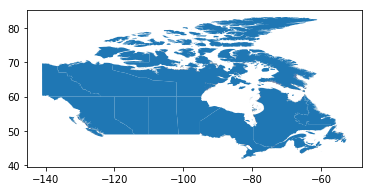

In [196]:
tmpWGS84.plot()

Shapes are here a GeoDataFrame containing all polygons illustrating the canadian province boundaries.

Now we can load the ERA5 gridded data. The parameter chunks is very important, it defines how big are the “pieces” of data moved from the disk to the memory. With this value the entire computation on a workstation with 32 GB takes a couple of minutes.

We will load all the temperature files for the year 2018 using Xarray library.

In [197]:
model='ERA5_T2m_1h'
t_in = 'J:/REANALYSES/ERA5/T2m_1h/'        
data = t_in + model + '_2018*_sfc.nc'
ds = xr.open_mfdataset(data, chunks = {'time': 10})

The next function <b>assign_coords</b> will convert the longitude from the 0-360 range to -180,180 

In [199]:
ds = ds.assign_coords(longitude=(((ds.longitude + 180) % 360) - 180)).sortby('longitude')

Our xarray Dataset contains a single variable (t2m) which is stored as a dask.array. This is the result of loading files with open_mfdataset.

Now we will use  regionmask module to create a gridded mask with the function regions_cls documented here: https://regionmask.readthedocs.io/en/stable/generated/regionmask.Regions_cls.html#regionmask.Regions_cls

With this function we will create an object able to mask ERA5 gridded data.

In [7]:
province_mask_poly = regionmask.Regions_cls(name = 'PRENAME', numbers = list(range(0,13)), names = list(tmpWGS84.PRENAME), abbrevs = list(tmpWGS84.PRENAME), outlines = list(tmpWGS84.geometry.values[i] for i in range(0,13)))
province_mask_poly

13 'PRENAME' Regions ()
Newfoundland and Labrador Prince Edward Island Nova Scotia New Brunswick Quebec Ontario Manitoba Saskatchewan Alberta British Columbia Yukon Northwest Territories Nunavut

Now we are ready to apply the mask on the gridded dataset xarray ERA5.

We select only the first timestep to speed up the process.

In [8]:
mask = province_mask_poly.mask(ds.isel(time = 0), lat_name='latitude', lon_name='longitude')
mask.to_netcdf('ERA5_mask_Canadian_provinces.nc')

In [3]:
masque = xr.open_mfdataset('ERA5_mask_Canadian_provinces.nc')
lat_bnd = [84, 40]
lon_bnd = [-148, -50]
masque = masque.sel(longitude=slice(*lon_bnd), latitude=slice(*lat_bnd),)

Here's a function to make maps in the future. 

In [4]:
def make_figure():
    fig=plt.figure(figsize=(18,8), frameon=True) 
    ax = plt.axes(projection=ccrs.LambertConformal())
    ax.add_feature(cfeature.OCEAN.with_scale('50m'))      # couche ocean
    ax.add_feature(cfeature.LAND.with_scale('50m'))       # couche land
    ax.add_feature(cfeature.LAKES.with_scale('50m'))      # couche lac

    ax.add_feature(cfeature.BORDERS.with_scale('50m'), linestyle='dotted')    # couche frontieres
    ax.add_feature(cfeature.RIVERS.with_scale('50m'))     # couche rivières 
    coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',     # ajout de la couche cotière 
                                facecolor='none', name='coastline')
    ax.add_feature(coast, edgecolor='black')   
    return fig, ax


We can make a quick visualisation of our netcdf mask:

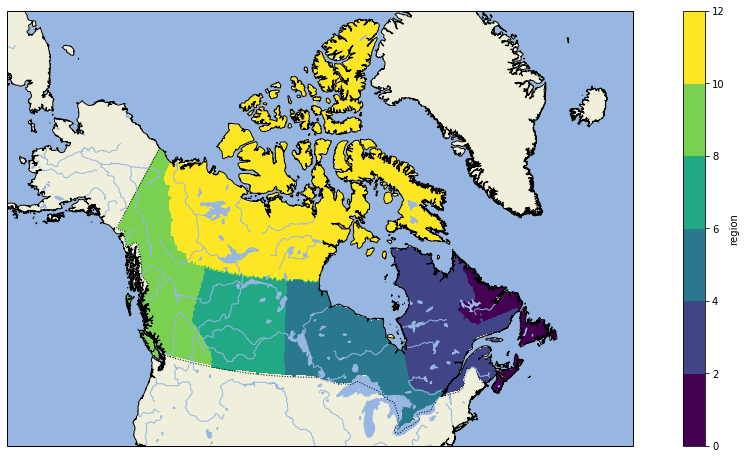

In [5]:
_, ax = make_figure()
ax.set_extent([-140,-50,32,82])
masque.region.plot.contourf(ax = ax, transform=ccrs.PlateCarree())

## Compute daily and monthly 2 meters temperature  mean 

We will now compute daily and monthly 2 meters temperature mean using hourly ERA5 datasets. To speed up our calcul, we will cut a subset over Canada only. 

Here's an example code just for one month and one year: 

In [6]:
model='ERA5_T2m_1h'

yi = 1990
yf = 1990
#########################################################
t_in = 'J:/REANALYSES/ERA5/T2m_1h/'
daily_out = 'J:/REANALYSES/ERA5/T2m_daily/' 
monthly_out = 'J:/REANALYSES/ERA5/T2m_monthly/' 
for year in range(yi,yf+1):                    # loop over years
    for i in range (1,2,1):                   # loop over months
        
        data = t_in + model + '_'+str(year) +'{:02d}'.format(i)+'_sfc.nc'
        ds = xr.open_mfdataset(data)        
        ds = ds - 273.15  # convert from Kelvin to Celcius 
        ds = ds.assign_coords(longitude=(((ds.longitude + 180) % 360) - 180)).sortby('longitude')
        
        lat_bnd = [84, 40]
        lon_bnd = [-148, -50]
        ds = ds.sel(longitude=slice(*lon_bnd), latitude=slice(*lat_bnd),)
        
        daily_mean = ds.groupby('time.day').mean('time')
        daily_mean.to_netcdf(daily_out + 'Daily_Mean_T2m_CAN_'+str(year) +'{:02d}'.format(i)+'.nc')
        
        monthly_mean = daily_mean.mean('day')
        monthly_mean.to_netcdf(monthly_out + 'Monthly_Mean_T2m_CAN_'+str(year) +'{:02d}'.format(i)+'.nc')


## Monthly climatologies and standardized anomalies

Once we have monthly mean values, we can now compute climatology and standard anomaly for monthly temperature from 1979 to 2019. Our reference climatology to compute standardized anomalies is 1990-2019 period.

We will first work with one month (ie january), we will make a loop over all months after. 

First we open and load datasets:

In [7]:
import xarray as xr 

#### First we open and load datasets
#for month in range (1,2,1):
m = 1
file = 'J:/REANALYSES/ERA5/T2m_monthly/Monthly_Mean_T2m_CAN_'
month = '{:02d}'.format(m)
multi_file = [f'{file}{year}{month}.nc' for year in range(1990,2020,1)]
ds_all = xr.concat([xr.open_dataset(f) for f in multi_file], 'time')
ds_all.time

<xarray.DataArray 'time' (time: 30)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], dtype=int64)
Dimensions without coordinates: time

Our time is without dimension, it's just an integer. To easly handle our fields, we can define a DatetimeIndex to change 'time' dimension in our Xarray. For more information: 

https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases

In [8]:
ds_all['time'] = pd.date_range('1990-'+month+'-01', freq='YS', periods=ds_all.time.shape[0])

In [11]:
ds_all.time.head()

<xarray.DataArray 'time' (time: 5)>
array(['1990-01-01T00:00:00.000000000', '1991-01-01T00:00:00.000000000',
       '1992-01-01T00:00:00.000000000', '1993-01-01T00:00:00.000000000',
       '1994-01-01T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1990-01-01 1991-01-01 ... 1994-01-01

We can compute our climatology and standard deviation over 30 years: 1990-2019 

In [12]:
clim_yi = 1990
clim_yf = 2019
ds_clim =  ds_all.sel(time=slice(str(clim_yi)+'-'+month+'-01', str(clim_yf)+'-'+month+'-01'))
data_clim = ds_clim.variables['t2m'][:].mean("time")
data_std  = ds_clim.variables['t2m'][:].std("time")


We can apply a function with .apply_unfunc and groupby methods to compute a standardized anomaly:

In [13]:
stand_anomalies = xr.apply_ufunc(
    lambda x, m, s: (x - m) / s,
    ds_all.groupby("time"),
    data_clim,
    data_std,
)

stand_anomalies.to_netcdf('J:/REANALYSES/ERA5/T2m_Month_Anomaly/Std_Anomaly_Monthly_Mean_T2m_CAN_'+
                          str(yi)+'-'+str(yf)+'_vs_'+str(clim_yi)+'-'+str(clim_yf)+'_'+str(month)+'.nc')

We will mask all Canadian provinces with applying our mask region created at the begining of this post:

In [15]:
data_clim_can = data_clim.where(masque.region >= 0)

We can now display january monthly mean temperature climatology: 

Text(0.5, 1.0, 'Climatology of monthly mean 2meters temperature: January')

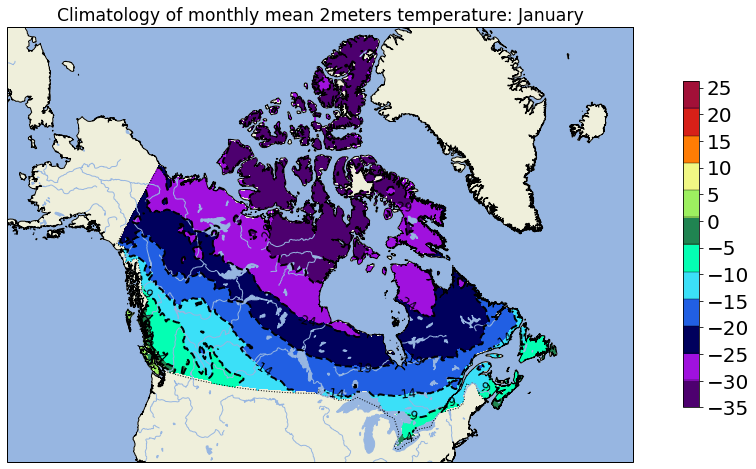

In [16]:
_, ax = make_figure()
ax.set_extent([-140,-50,32,82])
import matplotlib as mpl
import datetime
monthstr = datetime.date(1900, int(month), 1).strftime('%B')
data_levels = np.arange(-35, 30, 5.1)
Y=np.array([[77,0,111],[115,14,181],[160,17,222],[195,14,240],\
               [0,0,93],[21,38,177],[33,95,227],[32,162,247],[59,224,248],[202,255,250],\
               [4,255,179],[37,181,139],[32,132,81],[72,162,60],[157,240,96],[213,255,166],\
               [241,247,132],[248,185,68],[255,124,4],[235,78,14],[215,32,24],[189,24,40],[162,16,56],[135,16,65],[107,15,73]])/255.

colbar=mpl.colors.ListedColormap(Y)
mm = ax.contourf(data_clim_can.longitude,\
                   data_clim_can.latitude,\
                   data_clim_can,\
                   vmin=-35,\
                   vmax= 30, \
                   transform=ccrs.PlateCarree(),\
                   levels=data_levels,\
                   cmap=colbar )

data_contour = ax.contour(data_clim_can.longitude, data_clim_can.latitude, data_clim_can, 
                          levels = data_levels, 
                          linewidths=2, 
                          colors='k',
                          transform = ccrs.PlateCarree())
#Plot contour labels for the heights, leaving a break in the contours for the text (inline=True)
plt.clabel(data_contour,  data_levels, inline=True, fmt='%1i', fontsize=12)
# Define gridline locations and draw the lines using cartopy's built-in gridliner:
xticks = np.arange(-150.0,-40.0,20)
yticks =np.arange(10,80,10)

cbar = plt.colorbar(mm,  shrink=0.75, drawedges='True', ticks=np.arange(-35, 30.1, 5.), extend='both') # 2018

cbar.ax.tick_params(labelsize=20) 

string_title=u'Climatology of monthly mean 2meters temperature: ' + monthstr
plt.title(string_title, size='xx-large')

If we just want to display over one province, we can adjust our mask.  Let's plot climatology over Quebec: 

In [19]:
data_clim_qc = data_clim.where(masque.region == 4  )

Text(0.5, 1.0, 'ERA5 T2m Climatology (1990-2019) over Quebec January')

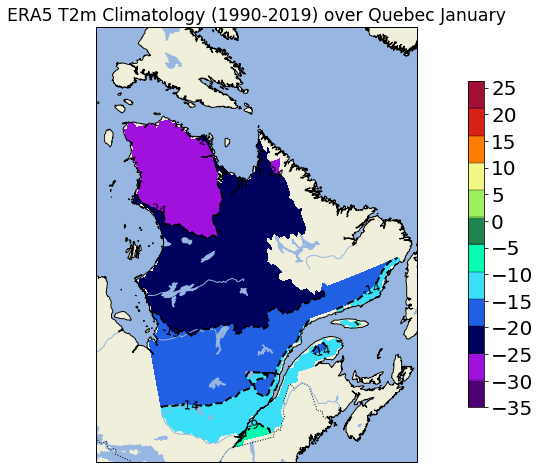

In [22]:
_, ax = make_figure()
ax.set_extent([-80,-60,45,65])
monthstr = datetime.date(1900, int(month), 1).strftime('%B')
data_levels = np.arange(-35, 30, 5.1)
Y=np.array([[77,0,111],[115,14,181],[160,17,222],[195,14,240],\
               [0,0,93],[21,38,177],[33,95,227],[32,162,247],[59,224,248],[202,255,250],\
               [4,255,179],[37,181,139],[32,132,81],[72,162,60],[157,240,96],[213,255,166],\
               [241,247,132],[248,185,68],[255,124,4],[235,78,14],[215,32,24],[189,24,40],[162,16,56],[135,16,65],[107,15,73]])/255.

colbar=mpl.colors.ListedColormap(Y)

data_levels = np.arange(-35, 30, 5.1)

mm = ax.contourf(data_clim_qc.longitude,\
                   data_clim_qc.latitude,\
                   data_clim_qc,\
                   vmin=-35,\
                   vmax= 30, \
                   transform=ccrs.PlateCarree(),\
                   levels=data_levels,\
                   cmap=colbar )

data_contour = ax.contour(data_clim_qc.longitude, data_clim_qc.latitude, data_clim_qc, 
                          levels = data_levels, 
                          linewidths=2, 
                          colors='k',
                          transform = ccrs.PlateCarree())
#Plot contour labels for the heights, leaving a break in the contours for the text (inline=True)
plt.clabel(data_contour,  data_levels, inline=True, fmt='%1i', fontsize=12)
# Define gridline locations and draw the lines using cartopy's built-in gridliner:
xticks = np.arange(-150.0,-40.0,20)
yticks =np.arange(10,80,10)

cbar = plt.colorbar(mm,  shrink=0.75, drawedges='True', ticks=np.arange(-35, 30.1, 5.), extend='both') # 2018

cbar.ax.tick_params(labelsize=20) 

string_title=u'ERA5 T2m Climatology (1990-2019) over Quebec ' + monthstr
plt.title(string_title, size='xx-large')

## Inter-annual standardised anomaly 

Let's compute and draw inter-annual standardised anomaly over Quebec: 

In [23]:
stand_anomalies_qc  = stand_anomalies.where(masque.region == 4)
stand_anomalie_serie = stand_anomalies_qc.mean(['latitude','longitude'])
stand_anomalie_serie.time.values[-1]

numpy.datetime64('2019-01-01T00:00:00.000000000')

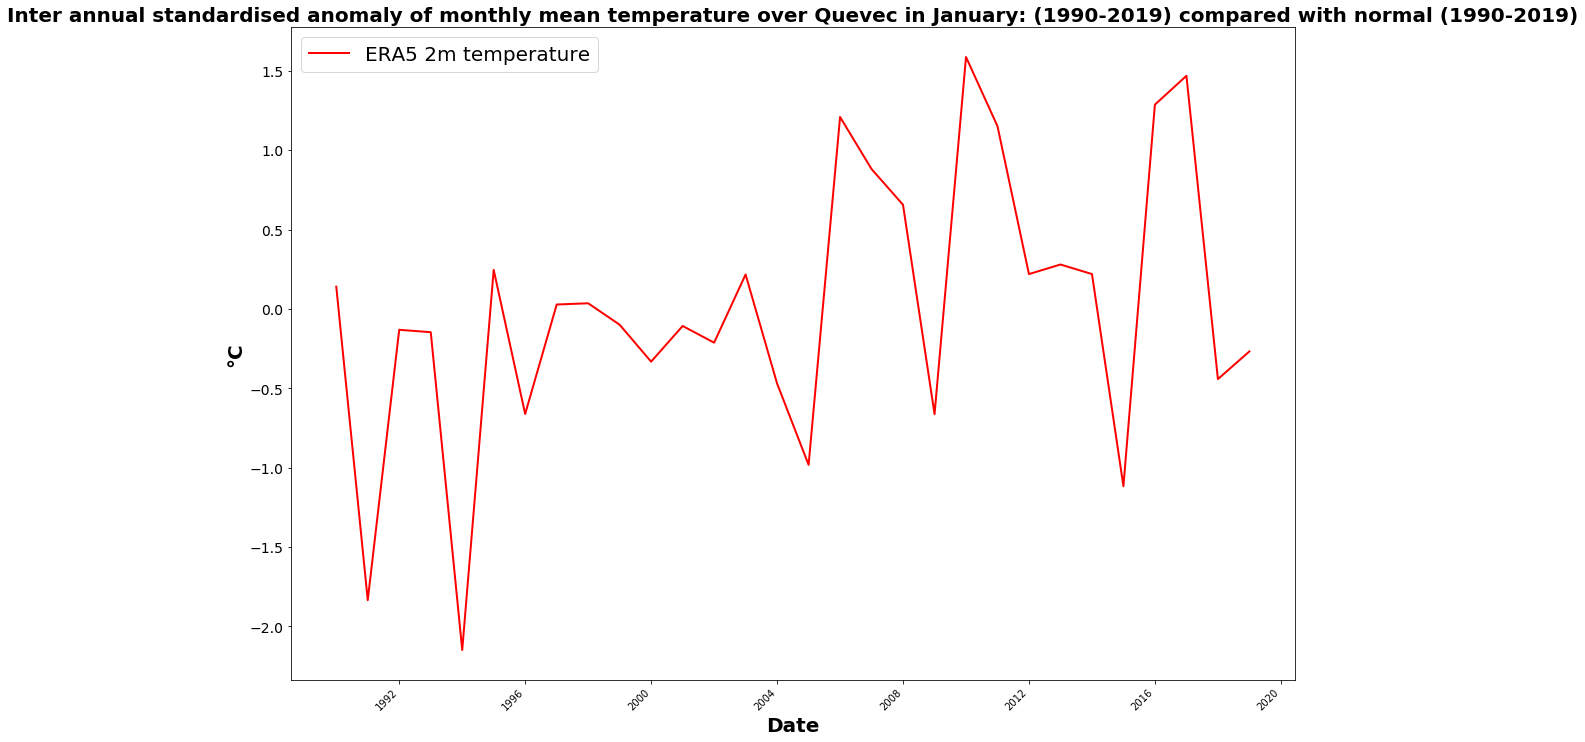

In [24]:
color = ['black','blue', 'red']
fig = plt.figure(figsize=(18, 12)) 


plt.rcParams["figure.figsize"]=[16,9]       #  
plt.plot(stand_anomalie_serie.time.values, stand_anomalie_serie.t2m.values, 
         label='ERA5 2m temperature', linewidth=2, c=color[2])
plt.legend(loc="upper left", markerscale=1., scatterpoints=1, fontsize=20)

plt.yticks( fontsize=14)

ax.grid(axis = "x", linestyle = "--", color='black', linewidth=0.25, alpha=0.5)
ax.grid(axis = "y", linestyle = "--", color='black', linewidth=0.25, alpha=0.5)

plt.setp(plt.gca().get_xticklabels(), rotation=45, ha="right")

plt.xlabel('Date', fontsize=20, color='black', weight='semibold')
plt.ylabel('°C', fontsize=20, color='black', weight='semibold')
plt.title('Inter annual standardised anomaly of monthly mean temperature over Quevec in January: (1990-2019) compared with normal (1990-2019)', fontsize=20, color='black', weight='semibold')
 
ax.set_facecolor('white')
plt.yticks( fontsize=14)
plt.show()  